In [1]:
# Imports and setup
import sys
from pathlib import Path
import warnings
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Ensure plots look decent
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Project paths
project_root = Path.cwd().parent
data_dir = project_root / 'data' / 'raw' / 'fx'
fig_dir = project_root / 'results' / 'figures'
metrics_dir = project_root / 'results' / 'metrics'
fig_dir.mkdir(parents=True, exist_ok=True)
metrics_dir.mkdir(parents=True, exist_ok=True)

# Import loader
sys.path.insert(0, str(project_root))
from src.fx_data_loader import FXDataLoader, FXDataMetadata, FXDataIntegrityError

print('✅ Environment ready')
print(f'Project root: {project_root}')

✅ Environment ready
Project root: /home/ghost/Quant _validation


In [2]:
# 1. Load data using fx_data_loader.py (GBPUSD hourly MID prices)
metadata = FXDataMetadata(
    source='Yahoo Finance (yfinance)',
    broker=None,
    price_type='mid',
    timezone='UTC',
    volume_type='none',
    spread_available=False,
    bar_interval='1h',
    dst_handling='utc_native',
)
loader = FXDataLoader(data_dir=str(data_dir), metadata=metadata)
df = loader.load_csv('GBPUSD', verify=True)
loader.print_integrity_report('GBPUSD')

# Keep necessary columns
df = df[['open','high','low','close']]
print(df.head())

FX DATA INTEGRITY REPORT: GBPUSD
Source: Yahoo Finance (yfinance)
Price Type: MID
Timezone: UTC
Volume Type: none
------------------------------------------------------------
Rows: 1,389
Period: 2025-10-20 23:00:00+00:00 to 2026-01-12 14:00:00+00:00
------------------------------------------------------------

📊 STATISTICS:
  weekend_gaps: 12
  suspicious_gaps: 2
  micro_gaps: 0
  zero_range_candles: 17
  zero_range_pct: 1.2239020878329734
  ohlc_violations: 0
  extreme_moves: 0
  duplicate_timestamps: 0
  long_stale_periods: 0
  zero_volume_bars: 1389
  estimated_median_range_pips: 11.165142059326172
  price_decimals: 16

⚠️ WARNINGS (6):
  - SUSPICIOUS GAPS: 2 gaps > 5 bars but < 24h. Possible missing data or DST issues.
First 5: {Timestamp('2025-12-25 22:00:00+0000', tz='UTC'): Timedelta('0 days 14:00:00'), Timestamp('2026-01-01 18:00:00+0000', tz='UTC'): Timedelta('0 days 08:00:00')}
  - ZERO-RANGE CANDLES: 17 (1.22%) bars have high==low. Either illiquid periods or bad data.
  - ZE

/home/ghost/Quant _validation/src/fx_data_loader.py:357: FXDataWarning: GBPUSD: SUSPICIOUS GAPS: 2 gaps > 5 bars but < 24h. Possible missing data or DST issues.
First 5: {Timestamp('2025-12-25 22:00:00+0000', tz='UTC'): Timedelta('0 days 14:00:00'), Timestamp('2026-01-01 18:00:00+0000', tz='UTC'): Timedelta('0 days 08:00:00')}
  warnings.warn(f"{pair}: {msg}", FXDataWarning)
/home/ghost/Quant _validation/src/fx_data_loader.py:357: FXDataWarning: GBPUSD: ZERO-RANGE CANDLES: 17 (1.22%) bars have high==low. Either illiquid periods or bad data.
  warnings.warn(f"{pair}: {msg}", FXDataWarning)
/home/ghost/Quant _validation/src/fx_data_loader.py:357: FXDataWarning: GBPUSD: ZERO VOLUME: 1389 (100.00%) bars have zero volume. Remember: this is TICK volume, not real volume.
  warnings.warn(f"{pair}: {msg}", FXDataWarning)
/home/ghost/Quant _validation/src/fx_data_loader.py:357: FXDataWarning: GBPUSD: TICK VOLUME WARNING: Volume column is tick count, NOT traded volume. Real FX volume is unknowabl

In [3]:
# 2. Compute hourly returns and drop NaNs
returns = df['close'].pct_change().dropna()
returns.name = 'ret'
print(f'Total returns: {len(returns)}')
print(returns.head())

Total returns: 1388
timestamp
2025-10-21 00:00:00+00:00    0.000724
2025-10-21 01:00:00+00:00   -0.001045
2025-10-21 02:00:00+00:00   -0.000576
2025-10-21 03:00:00+00:00    0.000013
2025-10-21 04:00:00+00:00   -0.000054
Name: ret, dtype: float64


## 3. Fat Tails Analysis
- Histogram with Normal and Student-t overlays
- Q-Q plot for normality
- Kurtosis, 3-sigma events, and Jarque-Bera test
- Save figure as `01_fat_tails.png`

Saved: /home/ghost/Quant _validation/results/figures/01_fat_tails.png
--- Fat Tails Diagnostics ---
Kurtosis (Fisher): 3.815
3-sigma events: 23
Jarque-Bera: stat=845.704, p=2.28e-184


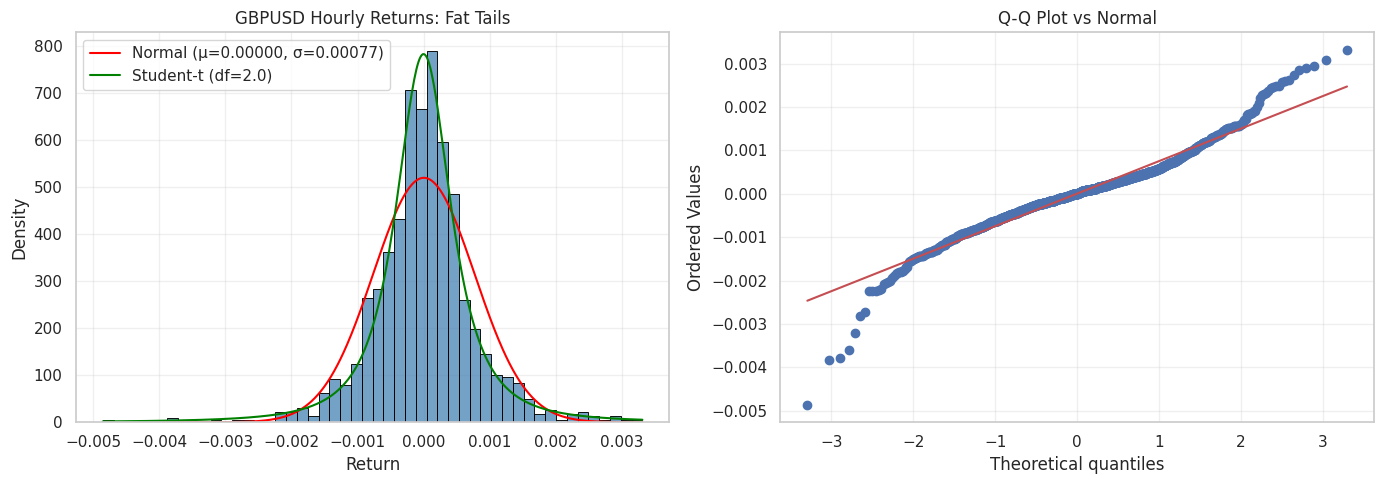

In [4]:
# Fit Normal and Student-t distributions
mu, sigma = returns.mean(), returns.std(ddof=1)
t_params = stats.t.fit(returns.values)  # df, loc, scale
df_t, loc_t, scale_t = t_params

# Compute stats
kurt = stats.kurtosis(returns, fisher=True)
jb_stat, jb_p = stats.jarque_bera(returns)
three_sigma_events = (np.abs(returns - mu) > 3 * sigma).sum()

# Plot histogram with overlays
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ax = axes[0]
sns.histplot(returns, bins=50, stat='density', edgecolor='black', color='steelblue', ax=ax)
x = np.linspace(returns.min(), returns.max(), 500)
ax.plot(x, stats.norm.pdf(x, mu, sigma), label=f'Normal (μ={mu:.5f}, σ={sigma:.5f})', color='red')
ax.plot(x, stats.t.pdf(x, df_t, loc_t, scale_t), label=f'Student-t (df={df_t:.1f})', color='green')
ax.set_title('GBPUSD Hourly Returns: Fat Tails')
ax.set_xlabel('Return')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True, alpha=0.3)

# Q-Q plot
ax = axes[1]
stats.probplot(returns, dist=stats.norm, plot=ax)
ax.set_title('Q-Q Plot vs Normal')
ax.grid(True, alpha=0.3)

fat_tails_path = fig_dir / '01_fat_tails.png'
plt.tight_layout()
plt.savefig(fat_tails_path, dpi=150)
print(f'Saved: {fat_tails_path}')

print('--- Fat Tails Diagnostics ---')
print(f'Kurtosis (Fisher): {kurt:.3f}')
print(f'3-sigma events: {three_sigma_events}')
print(f'Jarque-Bera: stat={jb_stat:.3f}, p={jb_p:.3g}')

## 4. Stationarity Analysis
- ADF test on returns
- Rolling 1-week mean and volatility (168 hours)
- Visual highlight for regime changes
- Save figure as `02_stationarity.png`

ADF: stat=-14.639, p=3.66e-27
Saved: /home/ghost/Quant _validation/results/figures/02_stationarity.png


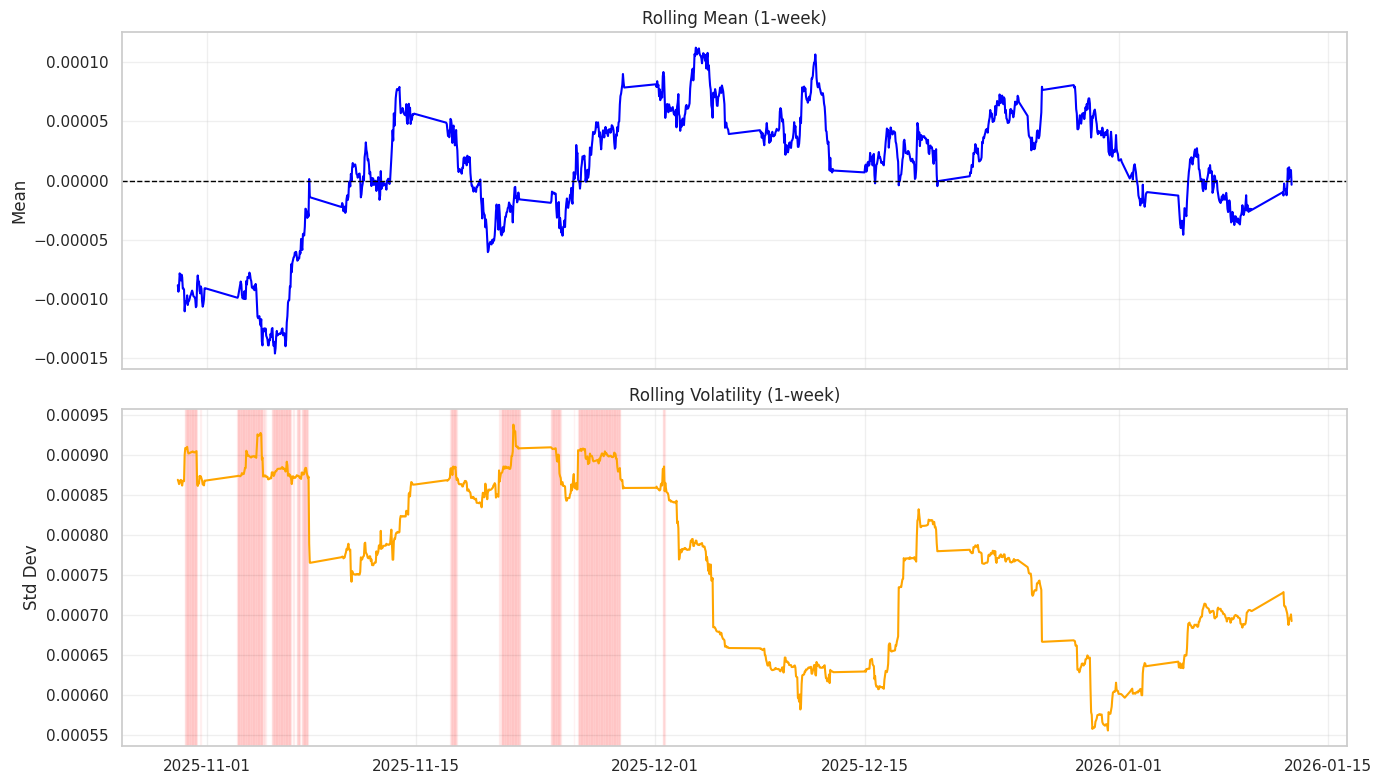

In [6]:
# ADF test
adf_stat, adf_p, _, _, _, _ = adfuller(returns, autolag='AIC')

# Rolling stats
window = 168  # 1 week of hourly bars
roll_mean = returns.rolling(window).mean()
roll_std = returns.rolling(window).std()

fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
ax[0].plot(returns.index, roll_mean, label='Rolling Mean (168h)', color='blue')
ax[0].axhline(0, color='black', linestyle='--', linewidth=1)
ax[0].set_title('Rolling Mean (1-week)')
ax[0].set_ylabel('Mean')
ax[0].grid(True, alpha=0.3)

ax[1].plot(returns.index, roll_std, label='Rolling Vol (168h)', color='orange')
ax[1].set_title('Rolling Volatility (1-week)')
ax[1].set_ylabel('Std Dev')
ax[1].grid(True, alpha=0.3)

# Highlight high volatility regimes (top 20% of rolling std)
threshold = roll_std.quantile(0.8)
high_vol = roll_std > threshold
# Use .items() instead of deprecated .iteritems()
for t, is_high in high_vol.items():
    if is_high:
        ax[1].axvspan(t, t + pd.Timedelta(hours=1), color='red', alpha=0.05)

stationarity_path = fig_dir / '02_stationarity.png'
plt.tight_layout()
plt.savefig(stationarity_path, dpi=150)
print(f'ADF: stat={adf_stat:.3f}, p={adf_p:.3g}')
print(f'Saved: {stationarity_path}')

## 5. Regime Analysis
- 20-hour rolling volatility
- Classify regimes: Low / Normal / High (tertiles)
- Mean, std, skew, kurtosis per regime
- Save distributions as `03_regimes.png` and CSV summary

/tmp/ipykernel_38290/3432211311.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary['tail_3sigma'] = reg_df.groupby('regime').apply(lambda g: (np.abs(g['ret'] - g['ret'].mean()) > 3*g['ret'].std(ddof=1)).sum())


Saved regime summary: /home/ghost/Quant _validation/results/metrics/gbpusd_regime_summary.csv
Saved: /home/ghost/Quant _validation/results/figures/03_regimes.png
            mean       std      skew      kurt  count  tail_3sigma
regime                                                            
High   -0.000004  0.000963 -0.295023  3.540700    466            8
Low    -0.000024  0.000570 -0.145131  0.699703    452            2
Normal  0.000046  0.000714  0.303467  1.029611    451            4
Saved: /home/ghost/Quant _validation/results/figures/03_regimes.png
            mean       std      skew      kurt  count  tail_3sigma
regime                                                            
High   -0.000004  0.000963 -0.295023  3.540700    466            8
Low    -0.000024  0.000570 -0.145131  0.699703    452            2
Normal  0.000046  0.000714  0.303467  1.029611    451            4


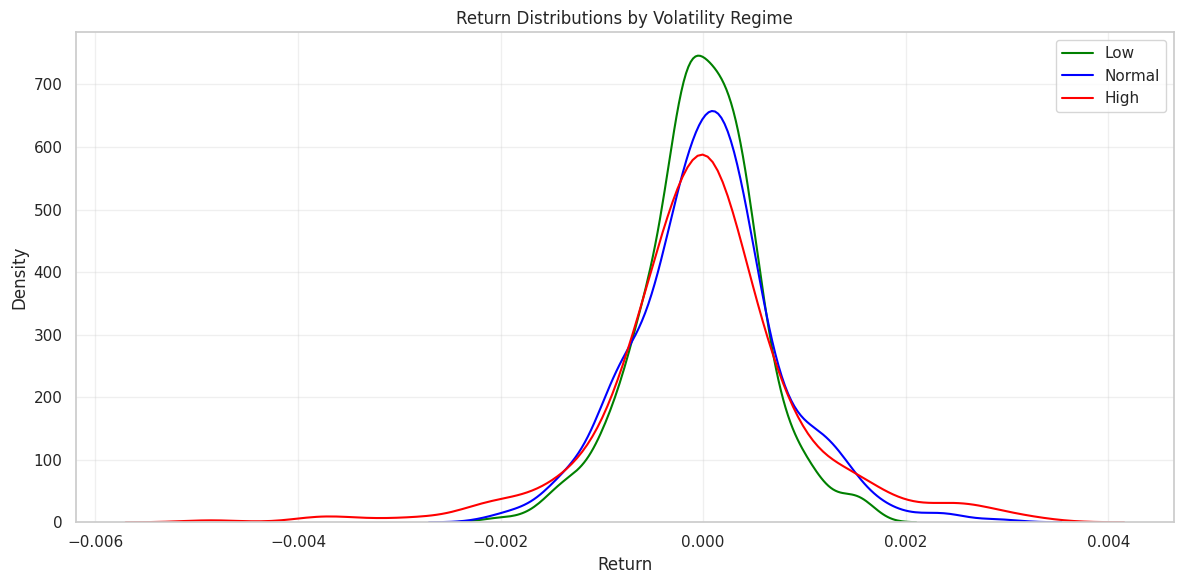

In [7]:
roll20 = returns.rolling(20).std()
q_low, q_high = roll20.quantile(0.33), roll20.quantile(0.66)
regime = pd.Series(index=roll20.index, dtype='object')
regime[roll20 <= q_low] = 'Low'
regime[(roll20 > q_low) & (roll20 <= q_high)] = 'Normal'
regime[roll20 > q_high] = 'High'
regime.name = 'Regime'

reg_df = pd.DataFrame({'ret': returns, 'vol20': roll20, 'regime': regime}).dropna()
summary = reg_df.groupby('regime').agg(
    mean=('ret','mean'),
    std=('ret','std'),
    skew=('ret', lambda x: stats.skew(x, bias=False)),
    kurt=('ret', lambda x: stats.kurtosis(x, fisher=True)),
    count=('ret','count'),
)
summary['tail_3sigma'] = reg_df.groupby('regime').apply(lambda g: (np.abs(g['ret'] - g['ret'].mean()) > 3*g['ret'].std(ddof=1)).sum())

# Save CSV summary
csv_path = metrics_dir / 'gbpusd_regime_summary.csv'
summary.to_csv(csv_path)
print(f'Saved regime summary: {csv_path}')

# Plot distributions by regime
fig, ax = plt.subplots(1, 1, figsize=(12,6))
for label, color in [('Low','green'),('Normal','blue'),('High','red')]:
    sns.kdeplot(reg_df[reg_df['regime']==label]['ret'], label=label, color=color, ax=ax)
ax.set_title('Return Distributions by Volatility Regime')
ax.set_xlabel('Return')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True, alpha=0.3)
regimes_path = fig_dir / '03_regimes.png'
plt.tight_layout()
plt.savefig(regimes_path, dpi=150)
print(f'Saved: {regimes_path}')
print(summary)

## 6. Autocorrelation Analysis
- ACF of returns, squared returns, and absolute returns
- Ljung-Box test
- Save figure as `04_autocorrelation.png`

Saved: /home/ghost/Quant _validation/results/figures/04_autocorrelation.png
Ljung-Box (returns):
      lb_stat  lb_pvalue
12  18.294452   0.107038
24  30.828137   0.158800
48  53.171752   0.281797
Ljung-Box (squared):
       lb_stat     lb_pvalue
12   49.585860  1.651628e-06
24   94.945214  2.156523e-10
48  159.793573  6.186608e-14
Ljung-Box (absolute):
       lb_stat     lb_pvalue
12  144.159766  8.644657e-25
24  269.418007  2.267351e-43
48  486.413369  7.665885e-74


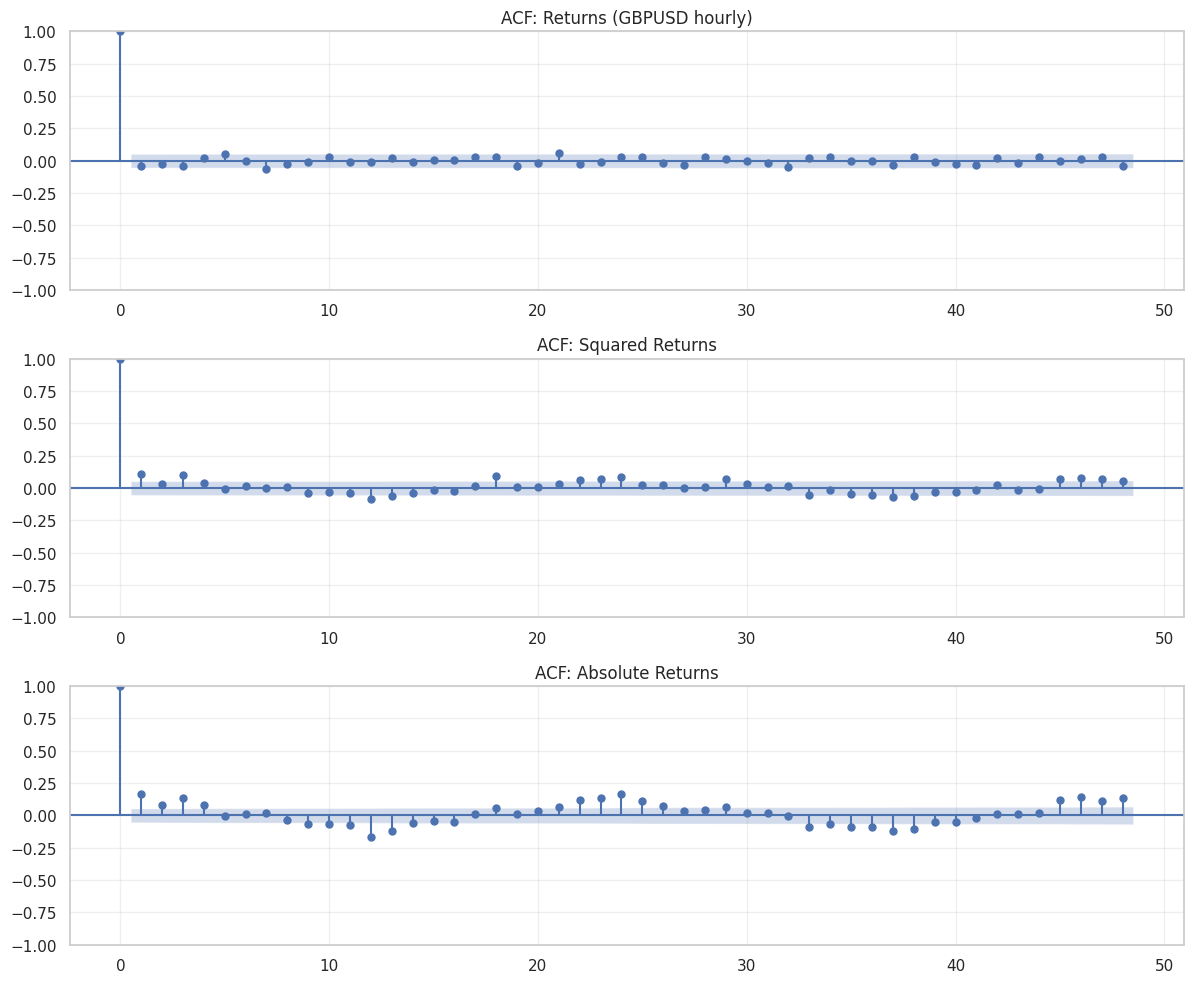

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10))
plot_acf(returns, ax=axes[0], lags=48)
axes[0].set_title('ACF: Returns (GBPUSD hourly)')
axes[0].grid(True, alpha=0.3)

plot_acf(returns**2, ax=axes[1], lags=48)
axes[1].set_title('ACF: Squared Returns')
axes[1].grid(True, alpha=0.3)

plot_acf(np.abs(returns), ax=axes[2], lags=48)
axes[2].set_title('ACF: Absolute Returns')
axes[2].grid(True, alpha=0.3)

auto_path = fig_dir / '04_autocorrelation.png'
plt.tight_layout()
plt.savefig(auto_path, dpi=150)
print(f'Saved: {auto_path}')

# Ljung-Box tests
lb_ret = acorr_ljungbox(returns, lags=[12,24,48], return_df=True)
lb_sq = acorr_ljungbox(returns**2, lags=[12,24,48], return_df=True)
lb_abs = acorr_ljungbox(np.abs(returns), lags=[12,24,48], return_df=True)
print('Ljung-Box (returns):')
print(lb_ret)
print('Ljung-Box (squared):')
print(lb_sq)
print('Ljung-Box (absolute):')
print(lb_abs)

## 7. Hypothesis-Specific Test
- Events: hourly moves > 0.5%
- Forward returns: 1h, 4h, 24h
- t-test vs 0, mean, std, win rate
- Save histogram as `05_hypothesis_test.png`

Events count (>0.5%): 0
Forward returns summary after >0.5% moves:
1h: {'mean': nan, 'std': nan, 'win_rate': nan, 'count': 0} t= nan p= nan
4h: {'mean': nan, 'std': nan, 'win_rate': nan, 'count': 0} t= nan p= nan
24h: {'mean': nan, 'std': nan, 'win_rate': nan, 'count': 0} t= nan p= nan


/tmp/ipykernel_38290/3609029665.py:20: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t, p = stats.ttest_1samp(x, 0.0)


Saved: /home/ghost/Quant _validation/results/figures/05_hypothesis_test.png


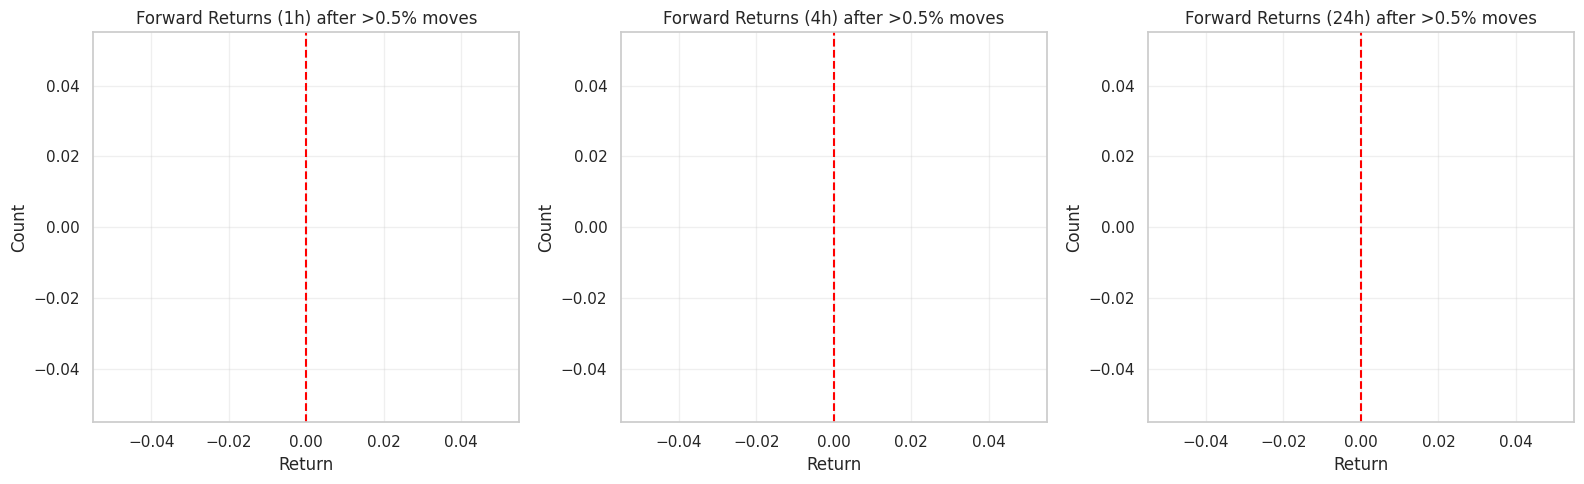

In [9]:
# Identify events
events = returns[np.abs(returns) > 0.005]  # > 0.5%
print(f'Events count (>0.5%): {len(events)}')

# Forward returns from prices
prices = df['close']
fwd_1h = prices.shift(-1) / prices - 1
fwd_4h = prices.shift(-4) / prices - 1
fwd_24h = prices.shift(-24) / prices - 1

fwd_df = pd.DataFrame({
    'ret': returns,
    'fwd_1h': fwd_1h,
    'fwd_4h': fwd_4h,
    'fwd_24h': fwd_24h
}).loc[events.index].dropna()

# t-tests
def ttest(x):
    t, p = stats.ttest_1samp(x, 0.0)
    return t, p

t1, p1 = ttest(fwd_df['fwd_1h'])
t4, p4 = ttest(fwd_df['fwd_4h'])
t24, p24 = ttest(fwd_df['fwd_24h'])

# Stats
def stats_summary(x):
    return {
        'mean': float(x.mean()),
        'std': float(x.std(ddof=1)),
        'win_rate': float((x > 0).mean()),
        'count': int(len(x))
    }

s1 = stats_summary(fwd_df['fwd_1h'])
s4 = stats_summary(fwd_df['fwd_4h'])
s24 = stats_summary(fwd_df['fwd_24h'])

print('Forward returns summary after >0.5% moves:')
print('1h:', s1, 't=', round(t1,3), 'p=', round(p1,4))
print('4h:', s4, 't=', round(t4,3), 'p=', round(p4,4))
print('24h:', s24, 't=', round(t24,3), 'p=', round(p24,4))

# Plot histograms
fig, axes = plt.subplots(1, 3, figsize=(16,5))
for ax, col, title in zip(axes, ['fwd_1h','fwd_4h','fwd_24h'], ['1h','4h','24h']):
    sns.histplot(fwd_df[col], bins=40, edgecolor='black', alpha=0.7, ax=ax)
    ax.axvline(0, color='red', linestyle='--')
    ax.set_title(f'Forward Returns ({title}) after >0.5% moves')
    ax.set_xlabel('Return')
    ax.set_ylabel('Count')
    ax.grid(True, alpha=0.3)
hypo_path = fig_dir / '05_hypothesis_test.png'
plt.tight_layout()
plt.savefig(hypo_path, dpi=150)
print(f'Saved: {hypo_path}')

## 8. Regime-Dependent Hypothesis Test
- Repeat hypothesis test per volatility regime
- Output mean, t-stat, p-value, and sample size per regime

In [10]:
# Merge regime with events DataFrame
events_df = pd.DataFrame({'ret': returns}).loc[events.index]
events_df = events_df.join(reg_df[['regime']])
events_fwd = events_df.join(fwd_df[['fwd_1h','fwd_4h','fwd_24h']])
events_fwd = events_fwd.dropna()

def regime_ttest(df, col):
    out = {}
    for r in ['Low','Normal','High']:
        x = df[df['regime']==r][col]
        if len(x) < 5:
            out[r] = {'mean': np.nan, 't': np.nan, 'p': np.nan, 'n': len(x)}
            continue
        t, p = stats.ttest_1samp(x, 0.0)
        out[r] = {'mean': float(x.mean()), 't': float(t), 'p': float(p), 'n': int(len(x))}
    return out

res_1h = regime_ttest(events_fwd, 'fwd_1h')
res_4h = regime_ttest(events_fwd, 'fwd_4h')
res_24h = regime_ttest(events_fwd, 'fwd_24h')

print('Regime-dependent hypothesis results:')
print('1h:', res_1h)
print('4h:', res_4h)
print('24h:', res_24h)

# Save CSV summaries
def save_regime_results(res, name):
    rows = []
    for r, d in res.items():
        rows.append({'regime': r, 'mean': d['mean'], 't': d['t'], 'p': d['p'], 'n': d['n']})
    pd.DataFrame(rows).to_csv(metrics_dir / f'gbpusd_{name}_regime_results.csv', index=False)

save_regime_results(res_1h, 'fwd1h')
save_regime_results(res_4h, 'fwd4h')
save_regime_results(res_24h, 'fwd24h')
print('Saved regime-dependent CSV results')

Regime-dependent hypothesis results:
1h: {'Low': {'mean': nan, 't': nan, 'p': nan, 'n': 0}, 'Normal': {'mean': nan, 't': nan, 'p': nan, 'n': 0}, 'High': {'mean': nan, 't': nan, 'p': nan, 'n': 0}}
4h: {'Low': {'mean': nan, 't': nan, 'p': nan, 'n': 0}, 'Normal': {'mean': nan, 't': nan, 'p': nan, 'n': 0}, 'High': {'mean': nan, 't': nan, 'p': nan, 'n': 0}}
24h: {'Low': {'mean': nan, 't': nan, 'p': nan, 'n': 0}, 'Normal': {'mean': nan, 't': nan, 'p': nan, 'n': 0}, 'High': {'mean': nan, 't': nan, 'p': nan, 'n': 0}}
Saved regime-dependent CSV results


## 9. Textual Summary
- Fat tails confirmed?
- Stationarity?
- Hypothesis significance?
- Sample size sufficient?
- Regime dependency?

In [ ]:
# Summarize diagnostics
summary_text = []

summary_text.append(f"Fat tails: Kurtosis={kurt:.3f}, JB p-value={jb_p:.3g}")
summary_text.append(f"Stationarity (ADF p-value): {adf_p:.3g}")
summary_text.append(f"Hypothesis (>0.5% moves) results: 1h p={p1:.3g}, 4h p={p4:.3g}, 24h p={p24:.3g}")
summary_text.append(f"Sample sizes: 1h={s1['count']}, 4h={s4['count']}, 24h={s24['count']}")

def regime_note(res):
    return ", ".join([f"{r}(n={d['n']}, p={d['p']:.3g})" for r,d in res.items() if not np.isnan(d['p'])])

summary_text.append('Regime dependency (p-values): ' + regime_note(res_1h))

print("\n".join(summary_text))

# Warnings
if s1['count'] < 30 or s4['count'] < 30 or s24['count'] < 30:
    print('⚠️ Low sample sizes for hypothesis tests - interpret cautiously.')
if jb_p < 0.05:
    print('⚠️ Fat tails / non-normality present - normal assumptions invalid.')
if (pd.Series([p1,p4,p24]) < 0.05).any():
    print('⚠️ Significant forward drift detected after large moves - check robustness.')

SyntaxError: unterminated string literal (detected at line 15) (3688948842.py, line 15)